# Basic Tutorial

Trey V. Wenger (c) June 2024

Here we demonstrate the various ways to use `mcmc_yplus`. We start by importing the package and generating some the example data.

In [1]:
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import mcmc_yplus
from mcmc_yplus.model import Model
from mcmc_yplus.plots import plot_pair

print("mcmc_yplus:", mcmc_yplus.__version__)

pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

mcmc_yplus: 0.0.2b


In [2]:
# Generate synthetic data
poly_coeffs = [1.0e-7, -2.0e-6, 0.0, 0.1]
H_centers = [-15.0, 20.0]
H_fwhms = [30.0, 35.0]
H_peaks = [10.0, 20.0]
He_H_fwhm_ratios = [0.9, 0.75]
ypluses = [0.06, 0.09]
He_offset = 122.15

channel = np.linspace(-300.0, 200.0, 1000)
rms = 1.0
spectrum = rng.normal(loc=0.0, scale=rms, size=1000)
spectrum += np.polyval(poly_coeffs, channel)
for H_center, H_fwhm, H_peak, He_H_fwhm_ratio, yplus in zip(H_centers, H_fwhms, H_peaks, He_H_fwhm_ratios, ypluses):
    # H component
    spectrum += H_peak * np.exp(-4.0 * np.log(2.0) * (channel - H_center)**2.0 / H_fwhm**2.0)
    
    # He component
    He_fwhm = H_fwhm * He_H_fwhm_ratio
    He_peak = H_peak * yplus / He_H_fwhm_ratio
    He_center = H_center - He_offset
    spectrum += He_peak * np.exp(-4.0 * np.log(2.0) * (channel - He_center)**2.0 / He_fwhm**2.0)
    
data = {
    "velocity": channel,
    "spectrum": spectrum,
    "noise": np.ones_like(spectrum) * rms,
}
print(data.keys())

dict_keys(['velocity', 'spectrum', 'noise'])


Here we create a data dictionary in the format expected by `mcmc_yplus`. Each dictionary element is a 1-D array of scalar values, where all of the arrays must have the same length. The `velocity` axis has units `km s-1` and the `spectrum` is the brightness temperature in `K`. The `noise` arrays define the channel-dependent rms spectral noise (in brightness temperature, `K`).

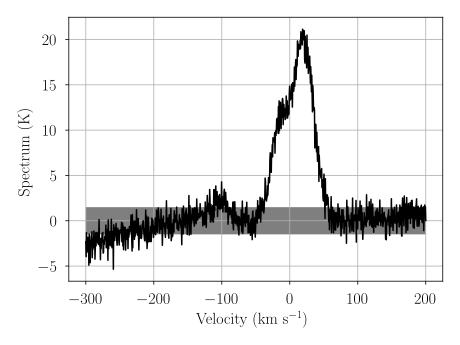

In [3]:
# Plot example data
fig, ax0 = plt.subplots()
ax0.plot(data["velocity"], data["spectrum"], "k-")
ax0.fill_between(
    data["velocity"],
    -1.5 * data["noise"],
    1.5 * data["noise"],
    color="k",
    edgecolor="none",
    lw=0,
    alpha=0.5,
)
ax0.set_ylabel("Spectrum (K)")
ax0.set_xlabel(r"Velocity (km s$^{-1}$)")
fig.tight_layout()
fig.savefig(f"{figdir}/data.{ext}")
plt.close(fig)

SVG(f"{figdir}/data.{ext}")

## `Model`

We begin with a two-cloud (`n_cloud=2`) model, with a 3rd order polynomial baseline (`baseline_degree=3`).

In [4]:
model = Model(data, n_clouds=2, baseline_degree=3, seed=1234, verbose=True)

# use default priors
# model.set_priors()

# manually set priors
model.set_priors(
    prior_H_amplitude = 10.0, # sigma of half-normal distribution (K)
    prior_H_center = [0.0, 25.0], # center and sigma of normal distribution (km s-1)
    prior_H_fwhm = 20.0, # mode of k=4 gamma distribution (km s-1)
    prior_yplus = 0.1, # sigma of half-normal distribution
    prior_He_H_fwhm_ratio = 0.1, # sigma of unity-centered truncated normal distribution
)

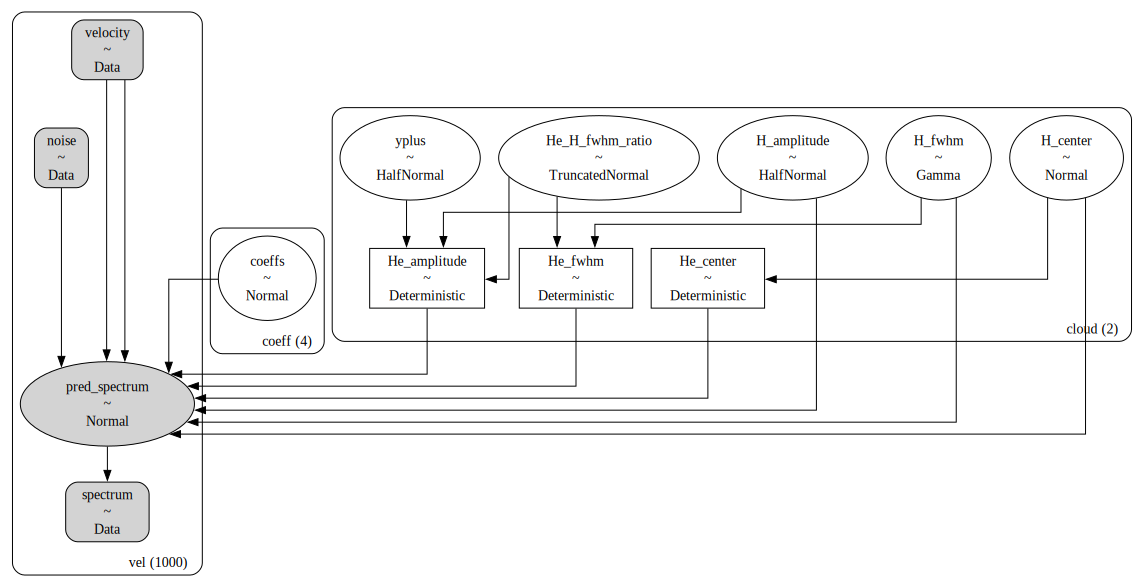

In [5]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [6]:
# model string representation
print(model.model.str_repr())

            coeffs ~ Normal(0, 1)
       H_amplitude ~ HalfNormal(0, 10)
          H_center ~ Normal(0, 25)
            H_fwhm ~ Gamma(4, f())
             yplus ~ HalfNormal(0, 0.1)
   He_H_fwhm_ratio ~ TruncatedNormal(1, 0.1, 0, inf)
      He_amplitude ~ Deterministic(f(He_H_fwhm_ratio, yplus, H_amplitude))
         He_center ~ Deterministic(f(H_center))
           He_fwhm ~ Deterministic(f(He_H_fwhm_ratio, H_fwhm))
pred_spectrum_norm ~ Normal(f(H_amplitude, coeffs, He_H_fwhm_ratio, yplus, H_fwhm, H_center), 1)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

In [7]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

Sampling: [H_amplitude, H_center, H_fwhm, He_H_fwhm_ratio, coeffs, pred_spectrum_norm, yplus]


We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

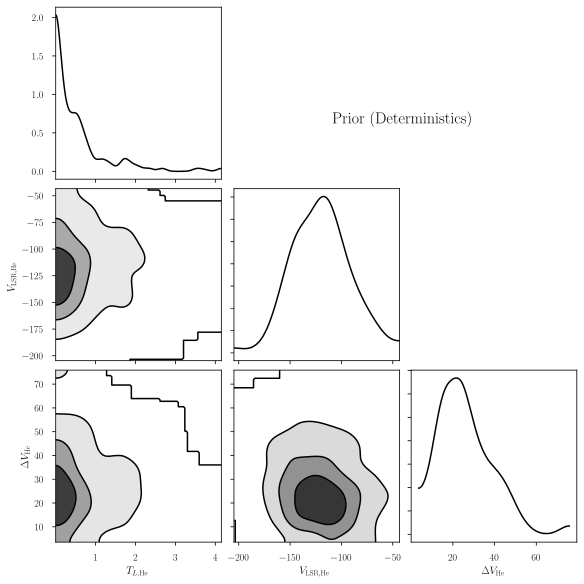

In [8]:
plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. If you get a `NaN` error, try increasing `learning_rate` and `abs_tolerance`.

In [9]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.03, # VI relative convergence threshold
    abs_tolerance = 0.03, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 76100
Interrupted at 76,099 [76%]: Average Loss = 1,568.5


In [10]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
H_amplitude[0]        9.894  0.153    9.540   10.132      0.005    0.004   
H_amplitude[1]       19.944  0.162   19.654   20.257      0.005    0.004   
H_center[0]         -15.804  0.289  -16.313  -15.232      0.009    0.006   
H_center[1]          19.792  0.164   19.470   20.100      0.005    0.004   
H_fwhm[0]            28.809  0.555   27.802   29.865      0.017    0.012   
H_fwhm[1]            36.813  0.314   36.197   37.344      0.010    0.007   
He_H_fwhm_ratio[0]    1.016  0.102    0.837    1.208      0.003    0.002   
He_H_fwhm_ratio[1]    0.845  0.065    0.729    0.980      0.002    0.002   
He_amplitude[0]       0.776  0.189    0.447    1.141      0.006    0.004   
He_amplitude[1]       2.216  0.240    1.773    2.668      0.008    0.005   
He_center[0]       -137.954  0.289 -138.463 -137.382      0.009    0.006   
He_center[1]       -102.358  0.164 -102.680 -102.050      0.005    0.004   
He_fwhm[0]           29.280  3.007   23.755   34.655      0.096    0.068   
He_fwhm[1]           31.092  2.395   26.604   35.888      0.079    0.056   
coeffs[0]             0.009  0.038   -0.057    0.083      0.001    0.001   
coeffs[1]             0.062  0.032   -0.006    0.118      0.001    0.001   
coeffs[2]            -0.291  0.027   -0.339   -0.235      0.001    0.001   
coeffs[3]             0.334  0.020    0.294    0.370      0.001    0.000   
yplus[0]              0.079  0.017    0.051    0.113      0.001    0.000   
yplus[1]              0.093  0.007    0.080    0.106      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
H_amplitude[0]         939.0     963.0    NaN  
H_amplitude[1]         904.0     840.0    NaN  
H_center[0]           1068.0     720.0    NaN  
H_center[1]            936.0     896.0    NaN  
H_fwhm[0]             1037.0     979.0    NaN  
H_fwhm[1]              933.0     870.0    NaN  
He_H_fwhm_ratio[0]     957.0     983.0    NaN  
He_H_fwhm_ratio[1]     928.0     820.0    NaN  
He_amplitude[0]       1069.0     969.0    NaN  
He_amplitude[1]        993.0     973.0    NaN  
He_center[0]          1068.0     720.0    NaN  
He_center[1]           936.0     896.0    NaN  
He_fwhm[0]             979.0    1024.0    NaN  
He_fwhm[1]             937.0     820.0    NaN  
coeffs[0]              813.0     847.0    NaN  
coeffs[1]             1002.0     918.0    NaN  
coeffs[2]             1023.0     983.0    NaN  
coeffs[3]             1027.0     900.0    NaN  
yplus[0]              1075.0     992.0    NaN  
yplus[1]               993.0     924.0    NaN

## MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI. We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [11]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.03, "abs_tolerance": 0.03, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 76100
Interrupted at 76,099 [76%]: Average Loss = 1,568.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Only 3 chains appear converged.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [12]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [13]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
H_amplitude[0]        9.932  0.281    9.426   10.483      0.007    0.005   
H_amplitude[1]       19.898  0.194   19.524   20.248      0.004    0.002   
H_center[0]         -15.721  0.656  -16.909  -14.473      0.018    0.012   
H_center[1]          19.835  0.392   19.115   20.559      0.010    0.007   
H_fwhm[0]            29.050  1.171   26.863   31.167      0.029    0.020   
H_fwhm[1]            36.644  0.785   35.168   38.142      0.021    0.015   
He_H_fwhm_ratio[0]    1.006  0.094    0.823    1.168      0.001    0.001   
He_H_fwhm_ratio[1]    0.846  0.071    0.708    0.982      0.001    0.001   
He_amplitude[0]       0.772  0.185    0.431    1.114      0.004    0.003   
He_amplitude[1]       2.188  0.196    1.817    2.546      0.003    0.002   
He_center[0]       -137.871  0.656 -139.059 -136.623      0.018    0.012   
He_center[1]       -102.315  0.392 -103.035 -101.591      0.010    0.007   
He_fwhm[0]           29.214  2.979   23.512   34.491      0.054    0.038   
He_fwhm[1]           30.986  2.702   25.638   35.861      0.049    0.035   
coeffs[0]            -0.009  0.084   -0.160    0.153      0.002    0.001   
coeffs[1]             0.064  0.099   -0.125    0.246      0.002    0.002   
coeffs[2]            -0.305  0.050   -0.395   -0.211      0.001    0.001   
coeffs[3]             0.326  0.048    0.233    0.414      0.001    0.001   
yplus[0]              0.078  0.019    0.042    0.113      0.000    0.000   
yplus[1]              0.093  0.009    0.076    0.110      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
H_amplitude[0]        1822.0    2160.0    1.0  
H_amplitude[1]        3005.0    2243.0    1.0  
H_center[0]           1432.0    1635.0    1.0  
H_center[1]           1432.0    1418.0    1.0  
H_fwhm[0]             1701.0    1877.0    1.0  
H_fwhm[1]             1468.0    1610.0    1.0  
He_H_fwhm_ratio[0]    3975.0    1945.0    1.0  
He_H_fwhm_ratio[1]    3088.0    2256.0    1.0  
He_amplitude[0]       2697.0    1771.0    1.0  
He_amplitude[1]       3320.0    2406.0    1.0  
He_center[0]          1432.0    1635.0    1.0  
He_center[1]          1432.0    1418.0    1.0  
He_fwhm[0]            3111.0    2197.0    1.0  
He_fwhm[1]            2985.0    2258.0    1.0  
coeffs[0]             2078.0    2093.0    1.0  
coeffs[1]             2259.0    1908.0    1.0  
coeffs[2]             2120.0    2219.0    1.0  
coeffs[3]             2146.0    2055.0    1.0  
yplus[0]              2562.0    1691.0    1.0  
yplus[1]              2540.0    2313.0    1.0

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [pred_spectrum_norm]


Output()

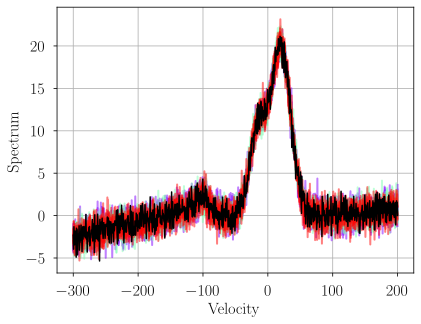

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=200, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [15]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the cloud parameters.

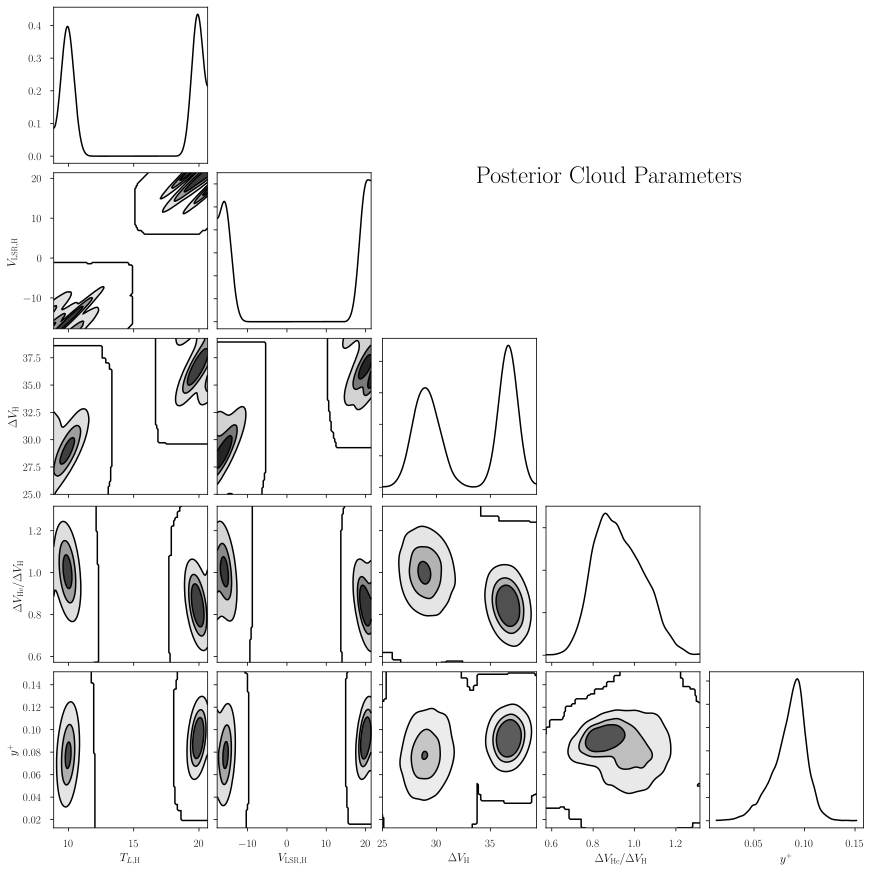

In [16]:
plot_pair(
    model.trace.solution_0, # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are two posterior modes. These correspond to the two clouds of the model. We can plot the posterior distributions for a single cloud.

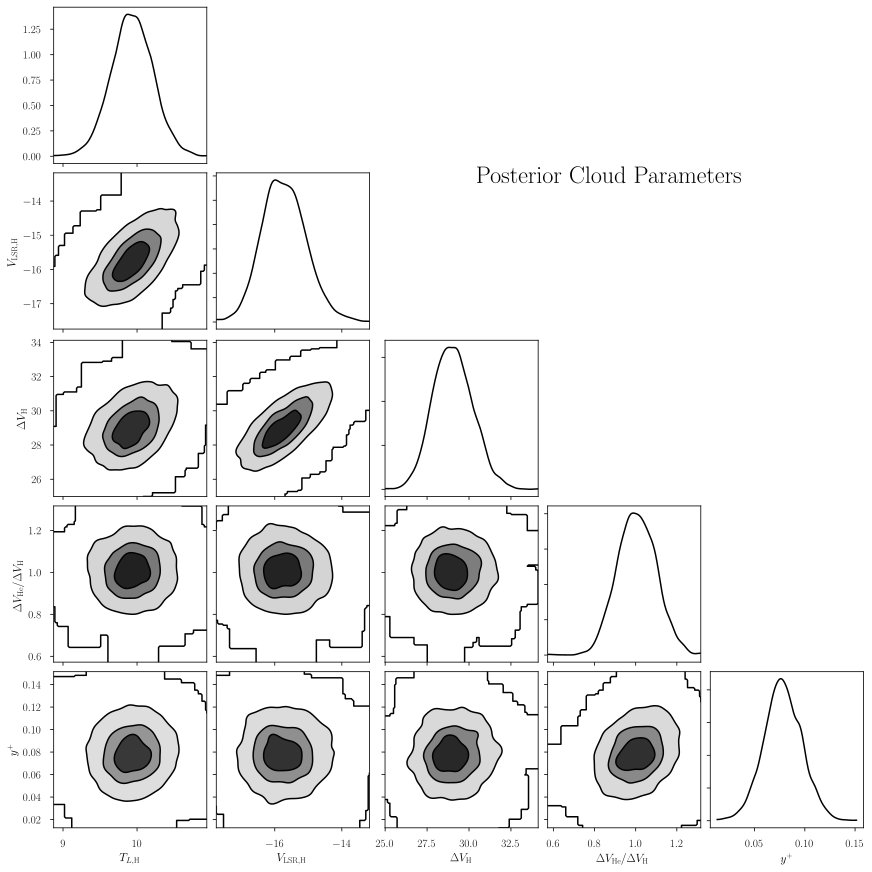

In [17]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [18]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_params + model.hyper_params, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 2902.3101455069527


mean     sd  hdi_16%  hdi_84%
H_amplitude[0]       9.932  0.281    9.688   10.238
H_amplitude[1]      19.898  0.194   19.701   20.076
H_center[0]        -15.721  0.656  -16.372  -15.099
H_center[1]         19.835  0.392   19.430   20.192
H_fwhm[0]           29.050  1.171   27.848   30.162
H_fwhm[1]           36.644  0.785   35.875   37.424
He_H_fwhm_ratio[0]   1.006  0.094    0.912    1.096
He_H_fwhm_ratio[1]   0.846  0.071    0.778    0.914
yplus[0]             0.078  0.019    0.060    0.097
yplus[1]             0.093  0.009    0.084    0.101